In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
import patsy
import os.path as op
from matplotlib.gridspec import GridSpec
import glob
import moss
%matplotlib inline

In [2]:
#read data
new_df = pd.read_csv('./new_df.csv')
new_df_l1so = pd.read_csv('./new_df_l1so.csv')
betas_df = pd.read_csv('./betas_df.csv')
pet_df = pd.read_csv(op.abspath('./dataframes/pet_pca.csv'))

cat_rule_map ={'High Reward':'High Reward\nStimuli',
              'Low Reward':'Low Reward\nStimuli'}
new_df['cat_rule'] = [cat_rule_map[x] for x in new_df['cat_rule']]
new_df_l1so['cat_rule'] = [cat_rule_map[x] for x in new_df_l1so['cat_rule']]

demog = pd.read_csv('../questionnaire_data.csv')
demog['sub'] = [int(x[2:]) for x in demog['subject']]
new_df = pd.merge(new_df,
         demog,
         on = ['sub'])

subs = list(set(new_df['sub']))
len(subs)

77

In [3]:
#plotting settings
fontsize = 18
ticksize = fontsize*.8
figy = 4
width = 16
sns.set_context('talk')
sns.__version__

'0.13.2'

In [4]:
# new_df['Age_MRI'].gro
from collections import Counter

age_sex = new_df.groupby(['sub','Sex'])['Age_MRI'].mean().reset_index()
print(Counter(age_sex['Sex']))

age_sex['Age_MRI'].std()

Counter({'Female': 48, 'Male': 29})


2.464304288318958

# Figure 1

In [5]:
salience_map = {'low': 'Low Reward\nStimuli',
               'high': 'High Reward\nStimuli'}


In [6]:
guess_df = new_df.groupby(['sub','block','drug','DRD2','COMT','stimulus','salience'])[['guess','VST_rac','VST_fmt']].mean().reset_index()

guess_df['cat_rule'] = [salience_map[x] for x in guess_df['salience']]
guess_df['categorical_rule'] = guess_df['salience']

guess_df = moss.remove_unit_variance(col = 'guess',unit = 'sub',df = guess_df, suffix = 'within')

md = smf.mixedlm("guess ~ C(drug,  Treatment(reference='plac'))*C(categorical_rule,Sum)", 
                 guess_df,
                 groups=guess_df['sub']).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                         Mixed Linear Model Regression Results
========================================================================================================================
Model:                                  MixedLM                      Dependent Variable:                      guess     
No. Observations:                       1808                         Method:                                  REML      
No. Groups:                             77                           Scale:                                   293.1930  
Min. group size:                        16                           Log-Likelihood:                          -7728.5174
Max. group size:                        24                           Converged:                               Yes       
Mean group size:                        23.5                                                                            
------------------------------------------------------------------------------------------------------------------------
                                                                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                                                     44.073    0.843 52.277 0.000 42.421 45.725
C(drug, Treatment(reference='plac'))[T.brom]                                  -0.597    0.980 -0.609 0.542 -2.517  1.323
C(drug, Treatment(reference='plac'))[T.tolc]                                  -1.052    0.992 -1.060 0.289 -2.997  0.893
C(categorical_rule, Sum)[S.high]                                              23.000    0.690 33.338 0.000 21.648 24.352
C(drug, Treatment(reference='plac'))[T.brom]:C(categorical_rule, Sum)[S.high] -3.919    0.979 -4.004 0.000 -5.838 -2.001
C(drug, Treatment(reference='plac'))[T.tolc]:C(categorical_rule, Sum)[S.high] -1.964    0.989 -1.986 0.047 -3.902 -0.026
Group Var                                                                     18.079    0.295                           
========================================================================================================================

"""

In [7]:
md = smf.mixedlm("guess ~ C(categorical_rule,Sum)", 
                 guess_df,
                 groups=guess_df['sub']).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
===========================================================================
Model:                   MixedLM       Dependent Variable:       guess     
No. Observations:        1808          Method:                   REML      
No. Groups:              77            Scale:                    295.4370  
Min. group size:         16            Log-Likelihood:           -7740.4151
Max. group size:         24            Converged:                Yes       
Mean group size:         23.5                                              
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        43.535    0.630 69.060 0.000 42.299 44.770
C(categorical_rule, Sum)[S.high] 21.048    0.404 52.068 0.000 20.255 21.840
Group Var                        17.953    0.294                           
===========================================================================

"""

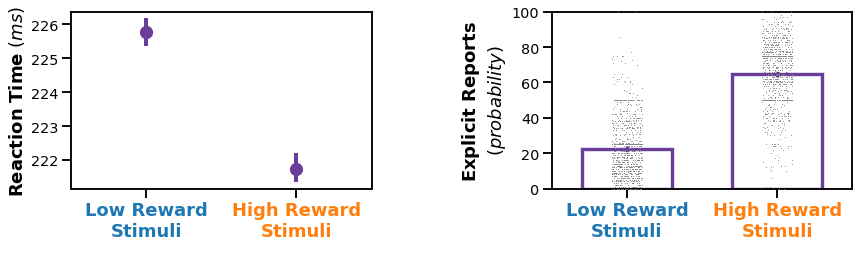

In [8]:
fig,ax=plt.subplots(1,2,
                    figsize=(14,3.25),#(16,18),
                    sharex=False,
                    sharey=False)

sns.pointplot(x = 'cat_rule',
               y = 'rt_within',
            order = ['Low Reward\nStimuli','High Reward\nStimuli'],
                color = sns.color_palette("Paired")[9],
            errorbar=('ci', 68),
            linestyle='none',
                  ax =ax[0],
               data = new_df)



g = sns.stripplot(x = 'cat_rule',
             y = 'guess',
            order = ['Low Reward\nStimuli','High Reward\nStimuli'],
                color = 'gray',
              size = 1,
              ax = ax[1],
                data = guess_df)
sns.barplot(x = 'cat_rule',
             y = 'guesswithin',
            order = ['Low Reward\nStimuli','High Reward\nStimuli'],
                color = sns.color_palette("Paired")[9],
            errorbar=('ci', 68),
            fill = False,
                width = .6,
                ax =ax[1],
                data = guess_df)


for n in range(2):
    ax[n].tick_params(axis = 'y',
                    labelsize=ticksize)

    #Change xtick colors
    colors = sns.color_palette()
    labels = ax[n].get_xticklabels()
    for l, c in zip(labels, colors):
        l.set_color(c)
        l.set_fontweight('bold')
        l.set_fontsize(fontsize)
        
##xlabels  
ax[1].set(xlabel = ' ')
ax[1].xaxis.get_label().set_fontsize(ticksize)

ax[0].set(xlabel = ' ')
ax[0].xaxis.get_label().set_fontsize(ticksize)

##ylabels  
ax[1].set(ylabel = '$\\bf{Explicit\ Reports}$\n$\it{(probability)}$')
ax[1].yaxis.get_label().set_fontsize(fontsize)

ax[0].set(ylabel = '$\\bf{Reaction\ Time}$ $\it{(ms)}$')
ax[0].yaxis.get_label().set_fontsize(fontsize)

ax[1].set(ylim = (0,100))

plt.subplots_adjust(hspace = .4,
                   wspace= .6)

plt.savefig('../figs/paper/fig1_figs.png',
                            bbox_inches = 'tight',
            dpi = 600)

In [9]:
df_model = new_df.dropna(subset = ['rt'])
md = smf.mixedlm("rt ~  C(rew_last_trial_bin,Sum) + C(categorical_rule,Sum)", 
                 groups=df_model['sub'],
                 data = df_model).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
==============================================================================
Model:                    MixedLM       Dependent Variable:       rt          
No. Observations:         28237         Method:                   REML        
No. Groups:               77            Scale:                    1924.3859   
Min. group size:          250           Log-Likelihood:           -147005.2943
Max. group size:          383           Converged:                Yes         
Mean group size:          366.7                                               
------------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
------------------------------------------------------------------------------
Intercept                        223.723    2.439 91.733 0.000 218.943 228.503
C(rew_last_trial_bin, Sum)[S.0]   -1.892    0.261 -7.247 0.000  -2.404  -1.380
C(categorical_rule, Sum)[S.high]  -2.025    0.261 -7.755 0.000  -2.537  -1.514
Group Var                        452.723    1.697                             
==============================================================================

"""

In [10]:
df_model = new_df_l1so.dropna(subset = ['rt'])
md = smf.mixedlm("rt ~  C(rew_last_trial_bin,Sum) + values +C(categorical_rule,Sum)", 
                 groups=df_model['sub'],
                 data = df_model).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Mixed Linear Model Regression Results
===============================================================================
Model:                   MixedLM        Dependent Variable:        rt          
No. Observations:        28237          Method:                    REML        
No. Groups:              77             Scale:                     1923.3596   
Min. group size:         250            Log-Likelihood:            -146993.4936
Max. group size:         383            Converged:                 Yes         
Mean group size:         366.7                                                 
-------------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z|  [0.025   0.975]
-------------------------------------------------------------------------------
Intercept                        226.157    2.514 89.962 0.000  221.230 231.084
C(rew_last_trial_bin, Sum)[S.0]   -2.015    0.263 -7.665 0.000   -2.530  -1.499
C(categorical_rule, Sum)[S.high]  -1.207    0.332 -3.638 0.000   -1.857  -0.557
values                           -71.288   17.818 -4.001 0.000 -106.211 -36.365
Group Var                        452.838    1.698                              
===============================================================================

"""

# Figure 2

### Figure 2A and 2B: Categorical and RL reaction time examples

In [11]:
corr_df = []

tmp_df = new_df.set_index(['sub','drug','stimulus'])
for idx in set(tmp_df.index):
    
    a = tmp_df.loc[idx].copy()
    a = a.dropna(subset = ['rt','rew_last_trial_bin'])

    r,p = scipy.stats.spearmanr(a['rt'],
                a['values'])


    sub_df = pd.DataFrame({'stim':idx[2],
                          'r':r,
                          'p':p,
                          'drug':idx[1],
                          'sub':idx[0]}, index = [0])
    corr_df.append(sub_df.copy())

corr_df = pd.concat(corr_df)


/var/folders/bn/dzh1ysw54m9cq4n3dnb30ldw0000gn/T/ipykernel_41304/3264220472.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  a = tmp_df.loc[idx].copy()


/var/folders/bn/dzh1ysw54m9cq4n3dnb30ldw0000gn/T/ipykernel_41304/2099648510.py:43: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(x = 'GrandTrial',


PearsonRResult(statistic=0.5020648410748209, pvalue=0.0034121132320102656)

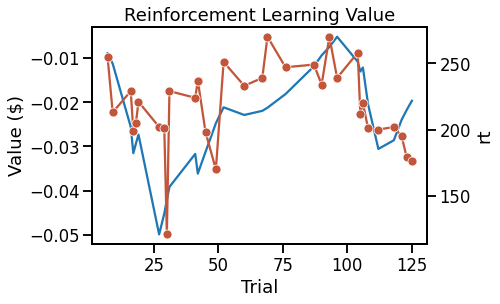

In [12]:
#plot example RT
a = new_df[new_df['sub'] == 158]
# a = a.loc[a['block'] == 0]
a = a.loc[a['drug'] == 'plac']

stim_map = {'A1_B1':'High Reward\nStimuli','A1_B2':'High Reward\nStimuli',
           'A2_B1':'Low Reward\nStimuli', 'A2_B2':'Low Reward\nStimuli'}
a[''] = [stim_map[x] for x in a['stimulus']]

stim_map = {'A1_B1':'1','A1_B2':'2',
           'A2_B1':'1', 'A2_B2':'2'}
a['stim_idx'] = [stim_map[x] for x in a['stimulus']]

# a = a.loc[a['stim_idx'] == '2']
a = a.loc[a['stimulus'] == 'A2_B2']

a['values'] = a['values']*-1

a = a.dropna(subset = ['rt','rew_last_trial_bin'])
md = smf.ols("rt ~ rew_last_trial_bin",
            data = a).fit()
a['rt_resid'] = md.resid.values

g = sns.lineplot(x = 'GrandTrial',
            y = 'values',
             hue_order = ['Low Reward\nStimuli',
                    'High Reward\nStimuli'],
             hue = '',
                              legend = False,
            data = a)


plt.xlabel("Trial", 
           fontsize = fontsize)

plt.ylabel("Value ($)", 
           fontsize = fontsize)
plt.title('Reinforcement Learning Value',
          fontsize = fontsize)

ax2 = g.twinx()

sns.lineplot(x = 'GrandTrial',
            y = 'rt',
             hue_order = ['Low Reward\nStimuli',
                    'High Reward\nStimuli'],
             hue = '',
             palette = [sns.diverging_palette(220, 20)[-1]],
             style  = '',   
             markers=True, dashes=False,
            ax = ax2,
             legend = False,
            data = a)


scipy.stats.pearsonr(a['rt_resid'],
                    a['values'])

### Figure 2A and 2B

In [13]:
## Get a dataframe with the salience difference effect for ease of visualization
mean_df = new_df.groupby(['sub','drug','block','salience','DRD2','COMT'])[['rt','guess','values']].mean()
mean_df = mean_df.reset_index().set_index(['sub','drug','block']).sort_index()
results = []
for sub, drug, block in set(mean_df.index):
    
    tmp = mean_df.loc[(sub, drug, block)]
    tmp = tmp.reset_index().set_index('salience')
    rt_diff = tmp.loc['high','rt'] - tmp.loc['low','rt']
    guess_diff = tmp.loc['high','guess'] - tmp.loc['low','guess']
    value_diff = tmp.loc['high','values'] - tmp.loc['low','values']

    
    temp = pd.DataFrame({'rt_diff':rt_diff,
                        'sub':sub,
                        'drug':drug,
                         'block':block,
                         'guess_diff':guess_diff,  
                         'value_diff': value_diff,
                        'DRD2':tmp.loc['low','DRD2'],
                        'COMT':tmp.loc['low','COMT']}, index = [0])
    
    results.append(temp.copy())
results = pd.concat(results)
results = pd.merge(pet_df, results, how = 'outer', on = ['sub'])
results = moss.remove_unit_variance(col = 'guess_diff',unit = 'sub', df = results)
results = moss.remove_unit_variance(col = 'rt_diff',unit = 'sub', df = results)
results['rt_diff'] = results['rt_diff']*-1

#average difference between guesses for high and low reward stimuli
r = results.groupby(['sub','drug'])[['rt_diff','guess_diff']].mean().reset_index()


merged = pd.merge(r,
                 betas_df,
                 on = ['sub','drug'])

#flip rt signs so positive indicates bigger effect
merged['rt_salience'] = merged['rt_salience']*-1
merged['rt_value'] = merged['rt_value']*-1

In [14]:
md = smf.mixedlm("guess_diff ~  C(drug,  Treatment(reference='plac'))*rt_diff", 
                 groups=merged['sub'],
                 data = merged).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Mixed Linear Model Regression Results
=================================================================================================
Model:                           MixedLM              Dependent Variable:              guess_diff
No. Observations:                226                  Method:                          REML      
No. Groups:                      77                   Scale:                           249.1095  
Min. group size:                 2                    Log-Likelihood:                  -978.2644 
Max. group size:                 3                    Converged:                       Yes       
Mean group size:                 2.9                                                             
-------------------------------------------------------------------------------------------------
                                                      Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-------------------------------------------------------------------------------------------------
Intercept                                             44.581    2.483 17.954 0.000  39.714 49.448
C(drug, Treatment(reference='plac'))[T.brom]          -7.921    2.923 -2.710 0.007 -13.649 -2.193
C(drug, Treatment(reference='plac'))[T.tolc]          -5.394    2.924 -1.845 0.065 -11.124  0.336
rt_diff                                                0.339    0.223  1.524 0.128  -0.097  0.776
C(drug, Treatment(reference='plac'))[T.brom]:rt_diff   0.048    0.337  0.141 0.888  -0.614  0.709
C(drug, Treatment(reference='plac'))[T.tolc]:rt_diff   0.250    0.310  0.806 0.420  -0.358  0.858
Group Var                                            158.868    3.082                            
=================================================================================================

"""

In [15]:
md = smf.mixedlm("guess_diff ~  C(drug,  Treatment(reference='plac'))*rt_salience + C(drug,  Treatment(reference='plac'))*rt_value", 
                 groups=merged['sub'],
                 data = merged).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                Mixed Linear Model Regression Results
=====================================================================================================
Model:                           MixedLM                Dependent Variable:                guess_diff
No. Observations:                226                    Method:                            REML      
No. Groups:                      77                     Scale:                             247.0409  
Min. group size:                 2                      Log-Likelihood:                    -986.5969 
Max. group size:                 3                      Converged:                         Yes       
Mean group size:                 2.9                                                                 
-----------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-----------------------------------------------------------------------------------------------------
Intercept                                                 44.693    2.644 16.906 0.000  39.512 49.875
C(drug, Treatment(reference='plac'))[T.brom]              -6.385    3.196 -1.998 0.046 -12.649 -0.121
C(drug, Treatment(reference='plac'))[T.tolc]              -4.846    3.096 -1.565 0.118 -10.915  1.222
rt_salience                                                0.986    0.475  2.074 0.038   0.054  1.917
C(drug, Treatment(reference='plac'))[T.brom]:rt_salience  -0.475    0.699 -0.679 0.497  -1.846  0.896
C(drug, Treatment(reference='plac'))[T.tolc]:rt_salience   0.278    0.652  0.426 0.670  -1.000  1.557
rt_value                                                   0.007    0.007  1.014 0.311  -0.006  0.020
C(drug, Treatment(reference='plac'))[T.brom]:rt_value     -0.009    0.011 -0.820 0.412  -0.031  0.013
C(drug, Treatment(reference='plac'))[T.tolc]:rt_value      0.004    0.010  0.417 0.677  -0.015  0.023
Group Var                                                160.463    3.115                            
=====================================================================================================

"""

### Figure 2E-F: RL/rule effects over learning

In [16]:
md = smf.mixedlm("guess ~ block*C(categorical_rule,Sum)", 
                 guess_df,
                 groups=guess_df['sub']).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
=================================================================================
Model:                     MixedLM         Dependent Variable:         guess     
No. Observations:          1808            Method:                     REML      
No. Groups:                77              Scale:                      293.8586  
Min. group size:           16              Log-Likelihood:             -7733.3736
Max. group size:           24              Converged:                  Yes       
Mean group size:           23.5                                                  
---------------------------------------------------------------------------------
                                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                              44.696    0.748 59.732 0.000 43.230 46.163
C(categorical_rule, Sum)[S.high]       20.350    0.570 35.693 0.000 19.233 21.468
block                                  -2.323    0.806 -2.881 0.004 -3.903 -0.743
block:C(categorical_rule, Sum)[S.high]  1.395    0.806  1.730 0.084 -0.185  2.975
Group Var                              18.020    0.295                           
=================================================================================

"""

In [17]:
#block effects
df_model = new_df.dropna(subset = ['rt'])
md = smf.mixedlm("rt ~  C(rew_last_trial_bin,Sum) + trial", 
                 groups=df_model['sub'],
                 data = df_model).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
=============================================================================
Model:                   MixedLM       Dependent Variable:       rt          
No. Observations:        28237         Method:                   REML        
No. Groups:              77            Scale:                    1926.2195   
Min. group size:         250           Log-Likelihood:           -147021.5364
Max. group size:         383           Converged:                Yes         
Mean group size:         366.7                                               
-----------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------------------
Intercept                       226.427    2.479 91.336 0.000 221.568 231.286
C(rew_last_trial_bin, Sum)[S.0]  -1.914    0.261 -7.324 0.000  -2.426  -1.402
trial                            -0.082    0.014 -5.783 0.000  -0.109  -0.054
Group Var                       451.721    1.693                             
=============================================================================

"""

In [18]:
#block effects
df_model = new_df.dropna(subset = ['rt'])
md = smf.mixedlm("rt ~  C(rew_last_trial_bin,Sum) + block*values +block*C(categorical_rule,Sum)", 
                 groups=df_model['sub'],
                 data = df_model).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Mixed Linear Model Regression Results
=====================================================================================
Model:                     MixedLM          Dependent Variable:          rt          
No. Observations:          28237            Method:                      REML        
No. Groups:                77               Scale:                       1920.6803   
Min. group size:           250              Log-Likelihood:              -146967.4552
Max. group size:           383              Converged:                   Yes         
Mean group size:           366.7                                                     
-------------------------------------------------------------------------------------
                                        Coef.  Std.Err.   z    P>|z|  [0.025   0.975]
-------------------------------------------------------------------------------------
Intercept                              228.119    2.556 89.245 0.000  223.109 233.129
C(rew_last_trial_bin, Sum)[S.0]         -1.996    0.263 -7.597 0.000   -2.511  -1.481
C(categorical_rule, Sum)[S.high]        -1.346    0.439 -3.065 0.002   -2.207  -0.485
block                                   -5.322    1.296 -4.107 0.000   -7.861  -2.782
block:C(categorical_rule, Sum)[S.high]  -0.194    0.661 -0.294 0.769   -1.489   1.101
values                                 -84.527   22.476 -3.761 0.000 -128.579 -40.474
block:values                            64.224   32.686  1.965 0.049    0.161 128.287
Group Var                              453.089    1.700                              
=====================================================================================

"""

In [19]:
#trial effects
df_model = new_df.dropna(subset = ['rt'])
md = smf.mixedlm("rt ~  C(rew_last_trial_bin,Sum) + GrandTrial*values +GrandTrial*C(categorical_rule,Sum)", 
                 groups=df_model['sub'],
                 data = df_model).fit()
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Mixed Linear Model Regression Results
==========================================================================================
Model:                        MixedLM           Dependent Variable:           rt          
No. Observations:             28237             Method:                       REML        
No. Groups:                   77                Scale:                        1918.9648   
Min. group size:              250               Log-Likelihood:               -146967.8053
Max. group size:              383               Converged:                    Yes         
Mean group size:              366.7                                                       
------------------------------------------------------------------------------------------
                                             Coef.  Std.Err.   z    P>|z|  [0.025   0.975]
------------------------------------------------------------------------------------------
Intercept                                   230.194    2.620 87.875 0.000  225.059 235.328
C(rew_last_trial_bin, Sum)[S.0]              -1.982    0.263 -7.547 0.000   -2.497  -1.467
C(categorical_rule, Sum)[S.high]             -1.325    0.592 -2.236 0.025   -2.486  -0.164
GrandTrial                                   -0.088    0.016 -5.687 0.000   -0.119  -0.058
GrandTrial:C(categorical_rule, Sum)[S.high]  -0.007    0.008 -0.825 0.409   -0.024   0.010
values                                      -91.041   29.640 -3.072 0.002 -149.135 -32.948
GrandTrial:values                             0.989    0.412  2.402 0.016    0.182   1.796
Group Var                                   452.899    1.700                              
==========================================================================================

"""

In [20]:
sns.light_palette("teal",6)
sns.color_palette("vlag",6)
sns.diverging_palette(220, 20)

[(0.24715576253545835, 0.49918708160096653, 0.5765599057376697),
 (0.5234922097901009, 0.678314343946672, 0.7264644010051908),
 (0.8025272551624646, 0.8591908959637222, 0.8778328073593089),
 (0.9140860646530862, 0.8246826885128927, 0.8028133239419792),
 (0.8384144678873866, 0.5785740917778832, 0.5129511551488873),
 (0.7634747047461135, 0.3348456555528834, 0.225892295531744)]

In [21]:
sns.light_palette("teal",6)
sns.color_palette("vlag",6)
sns.diverging_palette(35, 160)

[(0.6603380676503792, 0.40498692021594096, 0.2244211012045037),
 (0.7767090816202392, 0.620622886304544, 0.5112907096916208),
 (0.8942165312733986, 0.838364672374481, 0.8009617791991199),
 (0.7891494970188283, 0.8663717831455248, 0.8401653819747319),
 (0.5098015952034245, 0.6901878094015326, 0.6330597568331899),
 (0.2331553171966803, 0.5157077425602868, 0.4279570874473688)]

/var/folders/bn/dzh1ysw54m9cq4n3dnb30ldw0000gn/T/ipykernel_41304/787376388.py:23: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  g = sns.lineplot(x = 'GrandTrial',
/var/folders/bn/dzh1ysw54m9cq4n3dnb30ldw0000gn/T/ipykernel_41304/787376388.py:35: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(x = 'GrandTrial',
/var/folders/bn/dzh1ysw54m9cq4n3dnb30ldw0000gn/T/ipykernel_41304/787376388.py:199: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  plt.savefig('../figs/paper/fig2_figs.png',
/Users/ianballard/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_fig

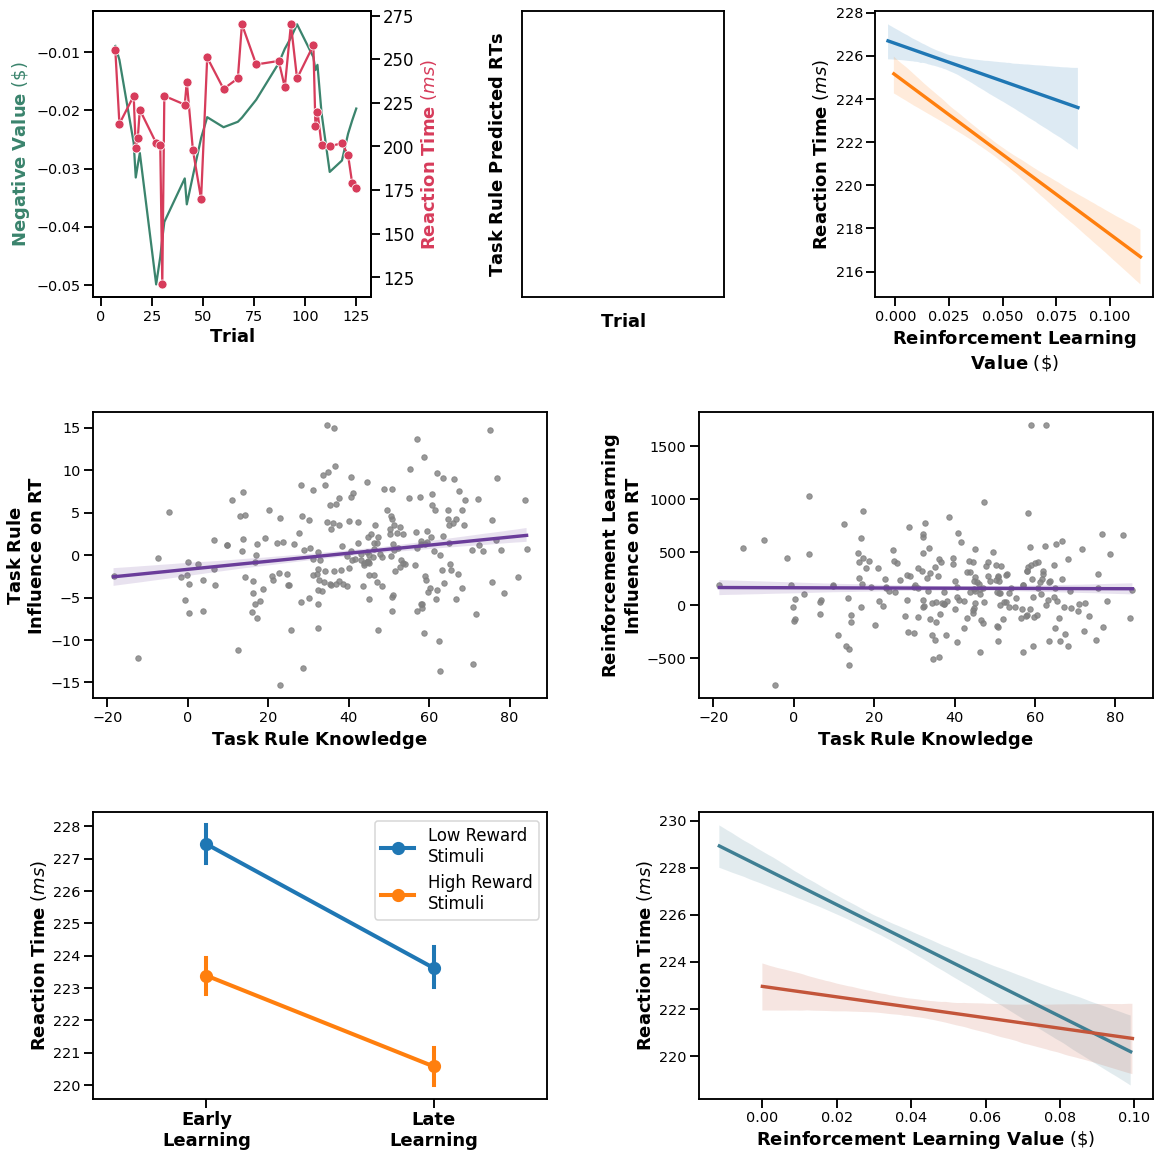

In [22]:
fig = plt.figure(layout="constrained",
                figsize=(19,20))
widths = [1,1,.4,.4,1,1]

gs = GridSpec(3, 6, 
              figure=fig,
              width_ratios=widths,
              hspace = .4,
              wspace = 3)

ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:])
ax4 = fig.add_subplot(gs[1, 0:3])
ax5 = fig.add_subplot(gs[1, 3:])
ax6 = fig.add_subplot(gs[2, 0:3])
ax7 = fig.add_subplot(gs[2, 3:])

#######################################################################################
##################         First ROW     #############################################
######################################################################################

g = sns.lineplot(x = 'GrandTrial',
            y = 'values',
             hue_order = ['Low Reward\nStimuli',
                    'High Reward\nStimuli'],
                                  palette = [sns.diverging_palette(160, 5)[0]],
             hue = '',
                              legend = False,
                                 ax = ax1,
            data = a)

ax_twin = g.twinx()

sns.lineplot(x = 'GrandTrial',
            y = 'rt',
             hue_order = ['Low Reward\nStimuli',
                    'High Reward\nStimuli'],
             hue = '',
             palette = [sns.diverging_palette(160, 5)[-1]],
             style  = '',   
             markers=True, 
             dashes=False,
            ax = ax_twin,
             legend = False,
            data = a)
ax_twin.set(ylabel = '$\\bf{Reaction\ Time}$ $\it{(ms)}$')
ax_twin.yaxis.get_label().set_fontsize(fontsize)
ax_twin.yaxis.get_label().set_color(sns.diverging_palette(160, 5)[-1])

##axislabels  
ax1.set(xlabel = '$\\bf{Trial}$')
ax1.xaxis.get_label().set_fontsize(fontsize)


##ylabels  
ax1.set(ylabel = '$\\bf{Value}$ $\it{(\$)}$')
ax1.yaxis.get_label().set_fontsize(fontsize)

ax1.tick_params(labelsize=ticksize)
ax1.set(xlim = (-4,132))
    
ax1.set(ylabel = '$\\bf{Negative\ Value}$ $\it{(\$)}$')
ax1.yaxis.get_label().set_color(sns.diverging_palette(160, 5)[0])


########################################################################################
###################         Top Middle     #############################################
#######################################################################################

ax2.set_xticks([])
ax2.set_yticks([])
ax2.set(ylabel = '$\\bf{Task\ Rule\ Predicted\ RTs}$')
ax2.set(xlabel = '$\\bf{Trial}$')
ax2.xaxis.labelpad = 15
ax2.yaxis.labelpad = 15


########################################################################################
###################         Top Right     #############################################
#######################################################################################

high_salience = new_df_l1so[new_df_l1so['cat_rule'] == 'High Reward\nStimuli']
low_salience = new_df_l1so[new_df_l1so['cat_rule'] == 'Low Reward\nStimuli']

g = sns.regplot(x = 'values',
          y = 'rt_within',
           scatter = False,
           ci = 68,
            ax = ax3,
          data = low_salience)
g = sns.regplot(x = 'values',
          y = 'rt_within',
           scatter = False,
           ci = 68,
            ax = ax3,
          data = high_salience)



ax3.set(ylabel = '$\\bf{Reaction\ Time}$ $\it{(ms)}$')
ax3.yaxis.get_label().set_fontsize(fontsize)
ax3.set(xlabel = '$\\bf{Reinforcement\ Learning\ Value}$ $\it{(\$)}$')
ax3.xaxis.get_label().set_fontsize(fontsize)
ax3.tick_params(labelsize=ticksize)
ax3.set(xlabel = '$\\bf{Reinforcement\ Learning}$\n$\\bf{Value}$ $\it{(\$)}$')

########################################################################################
###################         SECOND ROW     #############################################
#######################################################################################
g = sns.regplot(x = 'guess_diff',
          y = 'rt_salience',
           ci = 68,
           scatter_kws={'s':30,
                       'color':'grey'},
            color = sns.color_palette("Paired")[9],
           ax = ax4,
          data = merged)

g = sns.regplot(x = 'guess_diff',
          y = 'rt_value',
           ci = 68,
           scatter_kws={'s':30,
                       'color':'grey'},
            color = sns.color_palette("Paired")[9],
           ax = ax5,
          data = merged)
##axislabels  
for ax_id in [ax4,ax5]:
    ax_id.set(xlabel = '$\\bf{Task\ Rule\ Knowledge}$')
    ax_id.xaxis.get_label().set_fontsize(fontsize)

    ax_id.tick_params(labelsize=ticksize)

##ylabels  
ax4.set(ylabel = '$\\bf{Task\ Rule}$\n$\\bf{Influence\ on\ RT}$')
ax4.yaxis.get_label().set_fontsize(fontsize)

ax5.set(ylabel = '$\\bf{Reinforcement\ Learning}$\n$\\bf{Influence\ on\ RT}$')
ax5.yaxis.get_label().set_fontsize(fontsize)

    

########################################################################################
###################         THIRD ROW   left  #############################################
#######################################################################################  
fig_df = new_df.copy()
block_map = {0:'Early\nLearning',1:'Late\nLearning'}
fig_df[' '] = [block_map[x] for x in fig_df['block']]
fig_df[''] = fig_df['cat_rule']

g = sns.pointplot(x = ' ',
          y = 'rt',
           hue = '',
                hue_order = ['Low Reward\nStimuli','High Reward\nStimuli'],
           errorbar=('ci',68),
            ax = ax6,
          data = fig_df)

ax6.set(ylabel = '$\\bf{Reaction\ Time}$ $\it{(ms)}$')
ax6.yaxis.get_label().set_fontsize(fontsize)
ax6.set(xlabel = ' ')
ax6.xaxis.get_label().set_fontsize(ticksize)
ax6.tick_params(axis = 'y',
                    labelsize=ticksize)
labels = ax6.get_xticklabels()
for l in labels:
    l.set_fontweight('bold')
    l.set_fontsize(fontsize)
        

########################################################################################
###################         THIRD ROW  RIGHT   #############################################
####################################################################################### 
fig_df2 = fig_df[fig_df[' '] == 'Early\nLearning']
g = sns.regplot(x = 'values',
          y = 'rt_within',
            x_partial = 'salience_bin',
           scatter = False,
           color = sns.diverging_palette(220, 20)[0],#sns.color_palette()[2],
           ci = 68,
            ax = ax7,
          data = fig_df2)
fig_df3 = fig_df[fig_df[' '] == 'Late\nLearning']
g = sns.regplot(x = 'values',
          y = 'rt_within',
            x_partial = 'salience_bin',
           scatter = False,
           color = sns.diverging_palette(220, 20)[-1],#sns.color_palette()[6],
           ci = 68,
            ax = ax7,
          data = fig_df3)
ax7.set(ylabel = '$\\bf{Reaction\ Time}$ $\it{(ms)}$')
ax7.yaxis.get_label().set_fontsize(fontsize)
ax7.set(xlabel = '$\\bf{Reinforcement\ Learning\ Value}$ $\it{(\$)}$')
ax7.xaxis.get_label().set_fontsize(fontsize)
ax7.tick_params(labelsize=ticksize)

plt.savefig('../figs/paper/fig2_figs.png',
                            bbox_inches = 'tight',
            dpi = 600)

# Figure 3

In [23]:
pet = 'VST_rac'

df_model = new_df.dropna(subset = ['rt',pet])
df_model[pet] = scipy.stats.zscore(df_model[pet])

md = smf.mixedlm("rt ~   C(rew_last_trial_bin,Sum) +  values*C(drug,  Treatment(reference='plac'))*" + pet + "+C(categorical_rule,Sum)*C(drug,  Treatment(reference='plac'))*" + pet,
             df_model, 
             groups=df_model['sub']).fit()


md.summary()

/var/folders/bn/dzh1ysw54m9cq4n3dnb30ldw0000gn/T/ipykernel_41304/4033077220.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model[pet] = scipy.stats.zscore(df_model[pet])


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                Mixed Linear Model Regression Results
=====================================================================================================================================
Model:                                      MixedLM                          Dependent Variable:                          rt         
No. Observations:                           18948                            Method:                                      REML       
No. Groups:                                 52                               Scale:                                       2019.9724  
Min. group size:                            250                              Log-Likelihood:                              -99067.0369
Max. group size:                            383                              Converged:                                   Yes        
Mean group size:                            364.4                                                                                    
-------------------------------------------------------------------------------------------------------------------------------------
                                                                                       Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                              226.405    3.594 62.998 0.000  219.362 233.449
C(rew_last_trial_bin, Sum)[S.0]                                                         -2.112    0.329 -6.424 0.000   -2.756  -1.468
C(drug, Treatment(reference='plac'))[T.brom]                                            -2.857    1.923 -1.486 0.137   -6.626   0.911
C(drug, Treatment(reference='plac'))[T.tolc]                                             3.229    1.923  1.679 0.093   -0.540   6.998
C(categorical_rule, Sum)[S.high]                                                        -0.348    0.702 -0.496 0.620   -1.724   1.027
C(categorical_rule, Sum)[S.high]:C(drug, Treatment(reference='plac'))[T.brom]           -1.211    0.995 -1.217 0.224   -3.162   0.740
C(categorical_rule, Sum)[S.high]:C(drug, Treatment(reference='plac'))[T.tolc]           -0.592    0.996 -0.594 0.552   -2.544   1.360
values                                                                                 -98.227   34.854 -2.818 0.005 -166.539 -29.914
values:C(drug, Treatment(reference='plac'))[T.brom]                                     83.125   48.745  1.705 0.088  -12.413 178.664
values:C(drug, Treatment(reference='plac'))[T.tolc]                                     -8.778   49.392 -0.178 0.859 -105.585  88.029
VST_rac                                                                                 -3.203    3.584 -0.894 0.371  -10.228   3.821
C(drug, Treatment(reference='plac'))[T.brom]:VST_rac                                     6.438    1.892  3.402 0.001    2.729  10.147
C(drug, Treatment(reference='plac'))[T.tolc]:VST_rac                                     0.798    1.974  0.404 0.686   -3.071   4.667
C(categorical_rule, Sum)[S.high]:VST_rac                                                -1.990    0.713 -2.792 0.005   -3.387  -0.593
C(categorical_rule, Sum)[S.high]:C(drug, Treatment(reference='plac'))[T.brom]:VST_rac    3.041    0.990  3.073 0.002    1.102   4.981
C(categorical_rule, Sum)[S.high]:C(drug, Treatment(reference='plac'))[T.tolc]:VST_rac    1.140    1.006  1.133 0.257   -0.832   3.112
values:VST_rac                                                                          77.584   33.917  2.287 0.022   11.108 144.059
values:C(drug, Treatment(reference='plac'))[T.brom]:VST_rac                           -140.551   48.218 -2.915 0.004 -235.056 -46.045
values:C(drug, Treatment(reference='plac'))[T.tolc]:VST_rac                            -30.336   48.083 -0.631 0.

In [25]:
new_df['VST_fmt_split'] = 'High DA Synthesis Capacity'
new_df.loc[new_df['VST_fmt'] < new_df['VST_fmt'].median(), 'VST_fmt_split'] = 'Low DA Synthesis Capacity'


/var/folders/bn/dzh1ysw54m9cq4n3dnb30ldw0000gn/T/ipykernel_41304/2689557666.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fig_df['split'] = fig_df['VST_fmt_split']


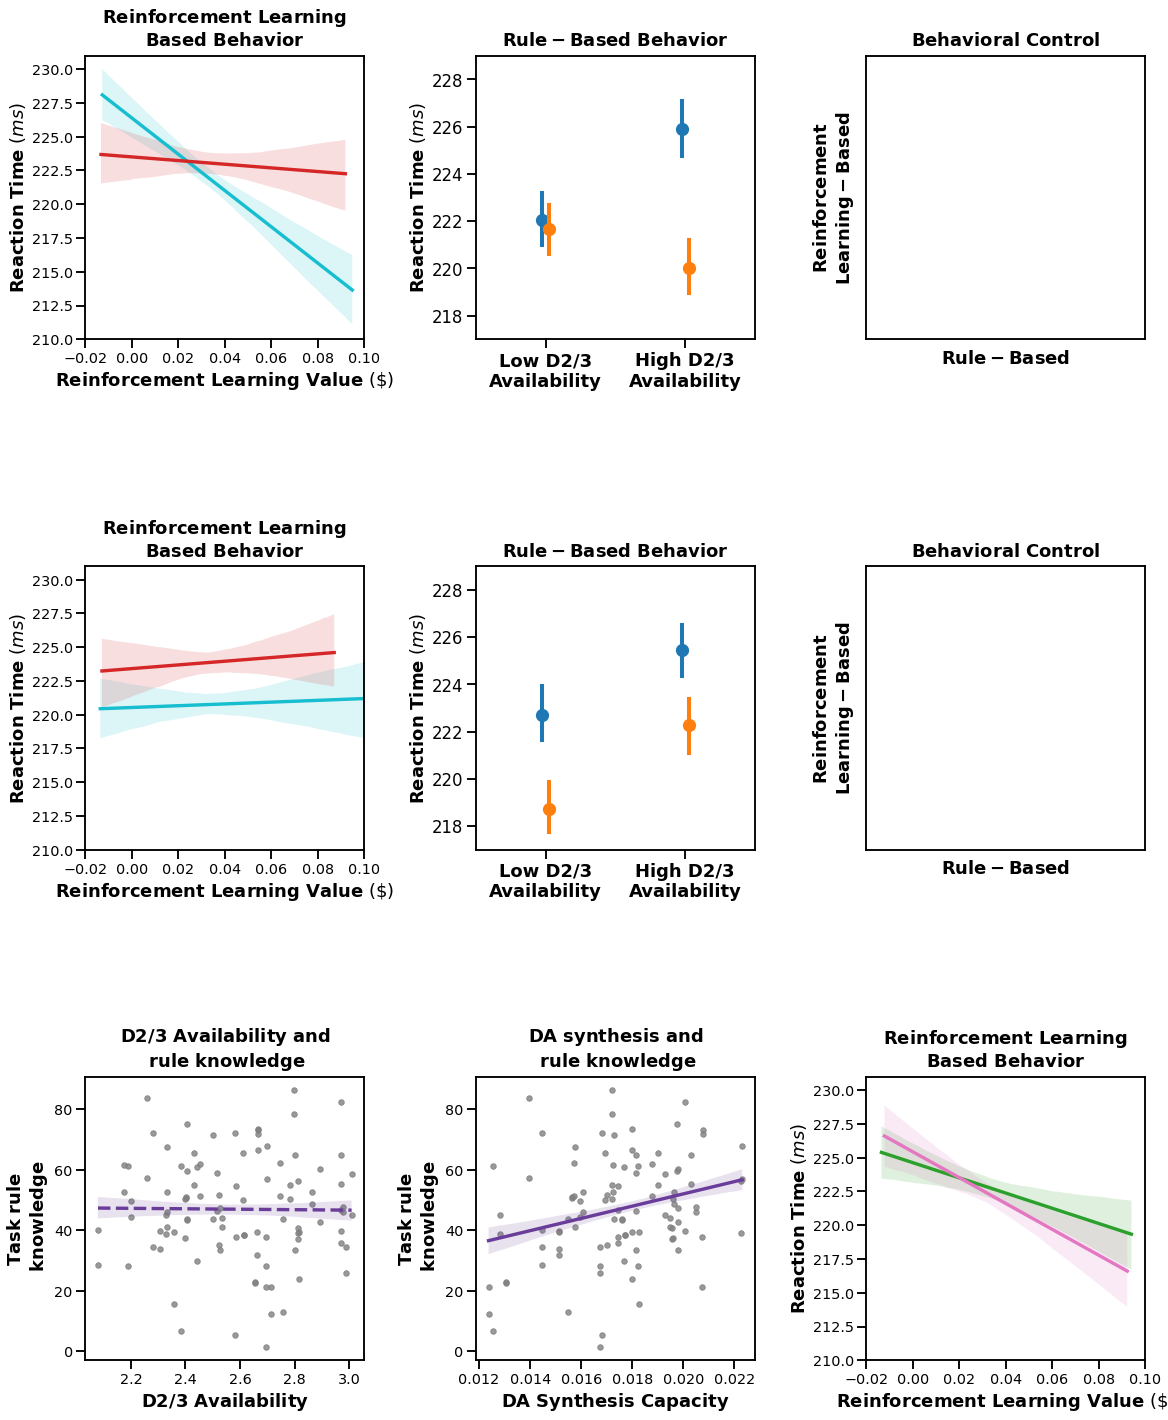

In [39]:
plt.rcParams['axes.titlepad'] = 10
fig,ax=plt.subplots(3,3,
                    figsize=(19,24),
                    sharex=False,
                    sharey=False)



for n,drug in enumerate(['plac','brom']):

    new_df['VST_rac_split'] = 'High D2/3\nAvailability'
    new_df.loc[new_df['VST_rac'] < new_df['VST_rac'].median(), 'VST_rac_split'] = 'Low D2/3\nAvailability'


    palette_map = {0:sns.color_palette()[9],
                   1:sns.color_palette()[3]}


    for j,split in enumerate(['Low D2/3\nAvailability',
                             'High D2/3\nAvailability']):
    
        fig_df = new_df[new_df['drug'] == drug].copy()
        fig_df = fig_df.dropna(subset = ['rt','VST_rac'])
        fig_df = fig_df[fig_df['VST_rac_split'] == split]

        g = sns.regplot(x = 'values',
              y = 'Reaction Time',
               x_partial = 'salience_bin',
               scatter = False,
                color = palette_map[j],
               ci = 68,
                ax = ax[n][0],
              data = fig_df)  

    
    ax[n][0].set(ylim = (210,231))
    ax[n][0].set(xlim = (-.02,.1))
    ax[n][0].set(ylabel = '$\\bf{Reaction\ Time}$ $\it{(ms)}$',
                title = '$\\bf{Reinforcement\ Learning}$\n$\\bf{Based\ Behavior}$')
    ax[n][0].yaxis.get_label().set_fontsize(fontsize)
    
    ax[n][0].set(xlabel = '$\\bf{Reinforcement\ Learning\ Value}$ $\it{(\$)}$')
    ax[n][0].xaxis.get_label().set_fontsize(fontsize)
    ax[n][0].tick_params(labelsize=ticksize)


    
    ########################################################################################
    ###################         Middle     ##########################################
    #######################################################################################

    
    fig_df = new_df[new_df['drug'] == drug].copy()
    fig_df = fig_df.dropna(subset = ['rt','VST_rac'])
    fig_df[''] = fig_df['cat_rule']
    fig_df[' '] = fig_df['VST_rac_split']
    

    g = sns.pointplot(x = ' ',
              y = 'Reaction Time',
                hue = '',
                hue_order = ['Low Reward\nStimuli','High Reward\nStimuli'],
                order = ['Low D2/3\nAvailability','High D2/3\nAvailability'],
                errorbar=('ci', 68),
                linestyle='none',
                dodge = .05,
                legend = False,
                  ax = ax[n][1],
                  data = fig_df)  


    ax[n][1].set(ylim = (217,229))

    ax[n][1].set(ylabel = '$\\bf{Reaction\ Time}$ $\it{(ms)}$',
                 title = '$\\bf{Rule-Based\ Behavior}$')
    ax[n][1].yaxis.get_label().set_fontsize(fontsize)

    labels = ax[n][1].get_xticklabels()
    for l in labels:
        l.set_fontweight('bold')
        l.set_fontsize(fontsize)

    ########################################################################################
    ###################         Right     ##########################################
    #######################################################################################

    
    ax[n][2].set_xticks([])
    ax[n][2].set_yticks([])
    ax[n][2].set(ylabel = '$\\bf{Reinforcement}$\n$\\bf{Learning-Based}$',
                xlabel = '$\\bf{Rule-Based}$',
                title = '$\\bf{Behavioral\ Control}$')
    ax[n][2].xaxis.labelpad = 10
    ax[n][2].yaxis.labelpad = 10
    ax[n][2].yaxis.get_label().set_fontsize(fontsize)
    ax[n][2].xaxis.get_label().set_fontsize(fontsize)


########################################################################################
###################         BOTTOM Left     ##########################################
#######################################################################################
r = results[results.drug =='plac']

g = sns.regplot(x = 'VST_rac',
           y = 'guess_diff_within',
           ci = 68,
            scatter_kws={'s':30,
                       'color':'grey'},
            color = sns.color_palette("Paired")[9],
                                line_kws={"ls":'dashed'},
               ax = ax[2][0],
           data = r)

ax[2][0].set(ylabel = '$\\bf{Task\ rule}$\n $\\bf{knowledge}$',
             title = '$\\bf{D2/3\ Availability\ and}$\n $\\bf{rule\ knowledge}$',
            xlabel = '$\\bf{D2/3\ Availability}$')

########################################################################################
###################         BOTTOM Middle     ##########################################
#######################################################################################
r = results[results.drug =='plac']

g = sns.regplot(x = 'VST_fmt',
           y = 'guess_diff_within',
           ci = 68,
            scatter_kws={'s':30,
                       'color':'grey'},
            color = sns.color_palette("Paired")[9],
               ax = ax[2][1],
           data = r)

ax[2][1].set(ylabel = '$\\bf{Task\ rule}$\n $\\bf{knowledge}$',
                          title = '$\\bf{DA\ synthesis\ and}$\n $\\bf{rule\ knowledge}$',
            xlabel = '$\\bf{DA\ Synthesis\ Capacity}$')
##axislabels  
for n in range(2):
    ax[2][n].xaxis.get_label().set_fontsize(fontsize)

    ax[2][n].tick_params(labelsize=ticksize)
########################################################################################
###################         BOTTOM LEFT     ##########################################
#######################################################################################
fig_df = new_df[new_df.drug == 'plac']
fig_df['split'] = fig_df['VST_fmt_split']
fig_df = fig_df.dropna(subset = ['rt','VST_fmt'])

fig_df2 = fig_df[fig_df['split'] == 'High DA Synthesis Capacity']
g = sns.regplot(x = 'values',
          y = 'rt_within',
            x_partial = 'salience_bin',
           scatter = False,
                color = sns.color_palette()[2],
           ci = 68,
           ax = ax[2][2],
          data = fig_df2)

fig_df3 = fig_df[fig_df['split'] == 'Low DA Synthesis Capacity']
g = sns.regplot(x = 'values',
          y = 'rt_within',
            x_partial = 'salience_bin',
           scatter = False,
                color = sns.color_palette()[6],
           ci = 68,
           ax = ax[2][2],
          data = fig_df3)

ax[2][2].set(ylim = (210,231))
ax[2][2].set(xlim = (-.02,.1))
ax[2][2].set(xlabel = '$\\bf{Reinforcement\ Learning\ Value}$ $\it{(\$)}$',
             ylabel = '$\\bf{Reaction\ Time}$ $\it{(ms)}$',
             title = '$\\bf{Reinforcement\ Learning}$\n$\\bf{Based\ Behavior}$')
ax[2][2].xaxis.get_label().set_fontsize(fontsize)
ax[2][2].yaxis.get_label().set_fontsize(fontsize)
ax[2][2].tick_params(labelsize=ticksize)


##save
plt.subplots_adjust(hspace = .8,
                   wspace = .4)

plt.savefig('../figs/paper/fig3_figs.png',
                            bbox_inches = 'tight',
            dpi = 600)

# Figure 5

In [ ]:
pet = 'VST_fmt'

df_model = new_df.dropna(subset = ['rt',pet]).copy()
df_model[pet] = scipy.stats.zscore(df_model[pet])

md = smf.mixedlm("rt ~   C(rew_last_trial_bin,Sum) +  values*C(drug,  Treatment(reference='plac'))*" + pet + "+C(categorical_rule,Sum)*C(drug,  Treatment(reference='plac'))*" + pet,
             df_model, 
             groups=df_model['sub']).fit()


md.summary()

### 5C: Relationship between fmt and guesses

In [ ]:
df_model = guess_df.copy().dropna(subset = ['VST_rac'])

pet = 'VST_fmt'
df_model[pet] = scipy.stats.zscore(df_model[pet])

md = smf.mixedlm("guess ~ C(categorical_rule, Sum)*C(drug,  Treatment(reference='plac'))*" + pet, 
                 df_model, 
                 groups=df_model['sub']).fit()
md.summary()

In [ ]:
df_model = guess_df.copy().dropna(subset = ['VST_rac'])

pet = 'VST_rac'
df_model[pet] = scipy.stats.zscore(df_model[pet])

md = smf.mixedlm("guess ~ C(categorical_rule, Sum)*C(drug,  Treatment(reference='plac'))*" + pet, 
                 df_model, 
                 groups=df_model['sub']).fit()
md.summary()

# Genetics

In [ ]:
df_model = new_df.dropna(subset = ['rt'])
md = smf.mixedlm("rt ~  C(rew_last_trial_bin,Sum) +  C(DRD2,Sum)*values*C(drug,  Treatment(reference='plac')) + C(DRD2,Sum)*C(categorical_rule,Sum)*C(drug,  Treatment(reference='plac'))", #
                 df_model, 
                 groups=df_model['sub']).fit()
md.summary()

In [ ]:
df_model = new_df.dropna(subset = ['rt'])

md = smf.mixedlm("rt ~  C(rew_last_trial_bin,Sum) +  C(COMT,Sum)*values*C(drug,  Treatment(reference='plac')) + C(COMT,Sum)*C(categorical_rule,Sum)*C(drug,  Treatment(reference='plac'))", #
                 df_model, 
                 groups=df_model['sub']).fit()
md.summary()

In [ ]:
pet = 'VST_rac2'

df_model = new_df.dropna(subset = ['rt',pet]).copy()
df_model[pet] = scipy.stats.zscore(df_model[pet])

md = smf.mixedlm("rt ~   C(rew_last_trial_bin,Sum) +  values*C(drug,  Treatment(reference='plac'))*" + pet + "+C(categorical_rule,Sum)*C(drug,  Treatment(reference='plac'))*" + pet,
             df_model, 
             groups=df_model['sub']).fit()


md.summary()